# Iterative vs Batch GP

A Python notebook regarding Gaussian Processes based primarily on the pre-prints of two papers: *Computation-Aware Gaussian Processes* and *Approximation-Aware Bayesian Optimization*.

## Problem Setup

Initially, we have some existing dataset $\mathcal{D}_{0} = \{(x_{i}, y_{i})\}_{i=1}^{n}$, with $x_{i} \in \mathbb{R}^{d}, y_{i} \in \mathbb{R}$. Equivalently, we let $\mathcal{D}_{0} = (\mathbf{X}, \mathbf{y})$, with $\mathbf{X} \in \mathbb{R}^{n \times d}, \mathbf{y} \in \mathbb{R}^{n}$. 

We want to use Gaussian Process regression to perform Bayesian optimization to find $x^{*} = \arg\max_{x \in \mathcal{X}}f(x)$, for the unknown objective function $f(\cdot): \mathcal{X} \to \mathbb{R}$, for some compact domain $\mathcal{X} \subset \mathbb{R}^{d}$.

Unfortunately, the standard `BayesOpt` formulation has $\mathcal{O}(n^3)$ time complexity, as the "proper" mathematical formulation requires a matrix inversion. To reduce the computational complexity, we include an "action matrix" $\mathbf{S}_{k} \in \mathbb{R}^{n \times k}$ for $k \ll n$ and performing Bayesian optimization on the "simplified" dataset $\mathcal{D}'_{0} = (\mathbf{S}_{k}^{\top}\mathbf{X}, \mathbf{S}_{k}^{\top}\mathbf{y})$, which yields $\mathcal{O}(kn^2)$ time complexity.

## Goal

The main goal is to perform Bayesian Optimization via Gaussian Process (GP) regression, with tweaks to the existing algorithms to reduce computational space and time complexity via approximation.

We will compare two methods for Bayesian Optimization which utilize action matrices to reduce the computational load. These methods are the `IterGP` algorithm, which builds the action matrix $\mathbf{S}_{k}$ column-by-column (i.e. at step $k$, we choose action $\mathbf{s}_{k} \in \mathbb{R}^{n \times 1}$, with $\mathbf{S}_{k}$ the concatenation of these columns), and the `BatchGP` algorithm, which optimizes $\mathbf{S}_{k} \in \mathbb{R}^{n \times k}$ in "one shot". 

In [103]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch

try:
    import jaxtyping
except ImportError:
    %pip install jaxtyping

from typing import Optional, Tuple
# Type hints are strictly optional, but personally I find that they make code more reasonable

from jaxtyping import Float, Integer
from collections.abc import Callable
# This package allows type annotations that include the size of torch Tensors/numpy arrays
# It's not necessary, but it helps with understanding what each function does

from torch import Tensor

%matplotlib inline

# Set DTYPE and DEVICE variables for torch tensors
DTYPE = torch.float32
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

import torch
import tqdm.notebook as tqdm

# Set a seed (for reproducibility)
# torch.manual_seed(2024)

# Gaussian Process Setup

For convenience, we will use a prior mean function $\mu = 0$ and the [Matérn covariance function](https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function) with $\nu = 5/2$ as the priors for our Bayesian optimization.

In [2]:
def mu(X: Float[Tensor, "N D"]) -> Float[Tensor, "N"]:
    r"""
    Computes the (very lame) zero mean function mu(X) = 0
    """

    return torch.zeros(*X.shape[:-1], dtype=X.dtype, device=X.device)

    # This return statement might seem like it's a pedantic way just to return the number 0 :)
    # It's not:
    # - if we want to compute a batch of GPs, the batch size of the returned zero
    #   tensor will match the batch size of X
    # - if X is a float64 tensor rather than float32, the returned zero tensor will match the correct dtype
    # - if X is on the GPU rather than the CPU, the returned zero tensor will also be on the same device

    # You don't always have to be this pedantic, but it's not a bad habit to get into

In [3]:
def matern_kernel(
    X1: Float[Tensor, "M D"], 
    X2: Float[Tensor, "N D"],
    ls: Float[Tensor, "1 D"], 
    os: Float[Tensor, "1 1"],
) -> Float[Tensor, "M N"]:
    r"""
    Computes Matern 5/2 kernel across all pairs of points (rows) in X1 & X2

    k(X1, X2) = os * (1 + \sqrt{5} * D + 5/3 * (D**2)) * exp(-\sqrt{5} * D)
    D = || (X1 - X2) / ls ||_2
    https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function

    ls: lengthscale
    os: outputscale
    """

    # Compute D, D ** 2, \sqrt{5} * D
    D_sq = (X1.div(ls).unsqueeze(-2) - X2.div(ls).unsqueeze(-3)).square().sum(dim = -1)
    # ^^^ This function is using broadcasting (via the unsqueeze operation)
    #     to compute all of the pairwise distances in parallel
    #
    #     You should also get into the habit of using "negative indexes"
    #     (i.e. unsqueeze(-2) rather than unsqueeze(0))
    #     as negative indices allow you to easily write parallel code for batched operations.
    #     (Again, not important now, but a good habit to develop!)
    
    D = torch.sqrt(D_sq + 1e-20)  # The 1e-20 is for numerical stability, so we don't get any NaNs if D≈0 but is very small and negative
    
    # Compute and return kernel
    return torch.mul(
        1 + (math.sqrt(5) * D) + ((5. / 3) * D_sq),
        torch.exp(-math.sqrt(5) * D)
    ).mul(os)

In [4]:
def compute_posterior_mean_and_variance(
    test_inputs: Float[Tensor, "M D"],
    X: Float[Tensor, "N D"],
    y: Float[Tensor, "N"],
    K_chol: Float[Tensor, "N N"],
    ls: Float[Tensor, "1 D"],
    os: Float[Tensor, "1 1"],
) -> tuple[Float[Tensor, "M"], Float[Tensor, "M M"]]:
    r"""
    Given inputs where we will evaluate the posterior, computes and returns the posterior moments
    - E[ f(test_inputs) | y ] = mu(test_inputs) + k(test_inputs, X) @ k(X, X)^{-1} @ (y - mu(X))
    - Cov[ f(test_inputs) | y ] = k(test_inputs, test_inputs) + k(test_inputs, X) @ k(X, X)^{-1} @ k(X, test_inputs)

    test_inputs:     the matrix containing test inputs we want to evaluate f() on
    X:               the matrix containing training inputs (where we have observations)
    y:               is the vector of training observations
    K_chol:          the Cholesky factor of the k(X, X) kernel matrix evaluated on training inputs
                     plus observational noise
                         i.e. K_chol @ K_chol.T = (k(X, X) + sigma^2 I)
    ls:              is the lengthscale of the kernel
    os:              is the outputscale of the kernel
    """

    # ^^^ Note:
    # You may be wondering why we are passing in K_chol,
    # rather than computing it as part of this function.
    # The reasoning will make sense once we start iteratively updating the posterior

    # Compute k(X, X)^{-1} k(X, test_inputs)
    # We need this term for both the posterior mean and posterior variance
    Ktest = matern_kernel(X, test_inputs, ls, os)
    K_inv_Ktest = torch.cholesky_solve(Ktest, K_chol, upper=False)

    # ***SUPER IMPORTANT:***
    # Note that we are using `cholesky_solve` to compute k(X, X)^{-1} k(X, test_inputs)
    # rather than calling k(X, X).inverse() @ Ktest
    # This is highly intentional
    # 1) Never call .inverse(); it is highly unstable. Always perform matrix solves instead.
    # 2) We can use the fact that k(X, X) is positive semi-definite to speed up solves.
    #    The way we exploit this is by first applying the Cholesky decomposition to k(X, X)
    #    (which exists because it is PSD) and then using it to perform a series of triangular
    #    solves (which are fast).

    # Compute posterior mean
    posterior_mean = mu(test_inputs) + (K_inv_Ktest.mT @ (y - mu(X)).unsqueeze(-1)).squeeze(-1)
    # Some notes:
    # 1) .mT is the same as .T, but it works with batched tensors
    #    i.e. it transposes the last two dimensions of the tensor
    #    this helper is useful if we want to use batched GPs
    # 2) (y - mu(X)).unsqueeze(-1) turns `y - mu(X)` from a N vector into a
    #    N x 1 matrix so that we can then use the matmul function with it.
    #    ().squeeze(-1) converts the resulting matmul back into a N vector.

    # Compute posterior covariance
    posterior_covar = matern_kernel(test_inputs, test_inputs, ls, os) - Ktest.mT @ K_inv_Ktest

    # Done!
    return posterior_mean, posterior_covar

In [5]:
def update_chol_newdata(
    K_chol: Float[Tensor, "N N"],
    X: Float[Tensor, "N D"],
    X_next: Float[Tensor, "N_next D"],
    ls: Float[Tensor, "1 D"],
    os: Float[Tensor, "1 1"],
    sigma_sq: Float[Tensor, ""],
    eps: float = 1e-4,
) -> Float[Tensor, "(N+N_next) (N+N_next)"]:
    """
    Computes the Cholesky factor of the block matrix
    [ k(X, X) + sigma_sq * I          k(X, X_next)                      ]
    [ k(X_next, X)                    k(X_next, X_next)  + sigma_sq * I ]
    where k is the kernel covariance

    This function should efficiently use prior computation.
    Given that we already have computed K_chol @ K_chol.T = k(X, X),
    we should be able to "update" that K_chol in O(N^2) time to get the
    desired block cholesky factorization.

    K_chol: Cholesky factorization of k(X, X) + sigma_sq * I
    X: Prior data
    X_next: Newly-added data
    ls: Length scale of the kernel covariance
    os: Output scale of the kernel covariance
    sigma_sq: Observation noise
    eps:      Small amount of noise to add to the diagonal for stability
    """

    # TODO: this function is currently not efficient :)
    # Right now, we're just computing the block Cholesky factorization from scratch,
    #     rather than reusing K_chol for an efficient update
    # You should make this function more efficient.

    X_joint = torch.cat([X, X_next], dim = -2)
    K_joint = matern_kernel(X_joint, X_joint, ls, os)

    # Add sigma_sq * I to K_joint
    #
    # *Important*: the Cholesky factorization can be a bit numerically unstable
    # If the smallest eigenvalues of K are ≈0, they can numerically appear to be slightly negative
    #     which causes the Cholesky factorization to fail
    # We can circumvent this problem by adding a small amount of diagonal noise to K_joint
    #     to bump up all of the eigenvalues
    I = torch.eye(K_joint.size(-1), dtype=K_joint.dtype, device=K_joint.device)
    K_joint = K_joint + (sigma_sq + eps) * I

    # Now we're ready to compute the Cholesky factor
    # return torch.linalg.cholesky(K_joint, upper=False)

    # Get the sub-blocks of K_joint
    N = X.size()[0]
    N_next = X_next.size()[0]
    K_11, K_12, K_22 = K_joint[0:N, 0:N], K_joint[0:N, N:], K_joint[N:, N:]

    # Cholesky factorization on the sub-blocks
    L_21 = torch.linalg.solve_triangular(K_chol, K_12, upper = False).mT
    L_22 = torch.linalg.cholesky(K_22 - L_21 @ L_21.mT, upper = False)

    # Concatenate sub-blocks of Cholesky decomposition matrix and return them in the form
    # [ K_chol      0 ]
    # [ L_21     L_22 ]
    return torch.cat(
        (torch.cat((K_chol, torch.zeros(N, N_next)), dim = -1), 
         torch.cat((L_21, L_22), dim = -1)
        ), dim = -2)

# Test Functions

We will use a few test functions to compare the performance of various Bayesian Optimization algorithms.

These include:
- A simple periodic function $f(x) = \sin(2\pi{x}) + \sin(4\pi{x})$ defined on $[-1, 1] \subset \mathbb{R}$.
- The ["Hartmann 6" function](https://www.sfu.ca/~ssurjano/hart6.html) defined on $[0, 1]^{6}$.

In [6]:
def simple_periodic(X: Float[Tensor, "N 1"]) -> Float[Tensor, "N"]:
    r"""
    Computes values of f(x) = sin(2pi*x) + sin(4pi*x)
    """

    ### TODO: Check if inputs are "valid" (possibly)

    return X[:, 0].mul(2 * math.pi).sin() + X[:, 0].mul(4 * math.pi).sin()  
    

In [7]:
def hartmann_six(X: Float[Tensor, "N 6"]) -> Float[Tensor, "N"]:
    r"""
    Computes the value of the Hartmann six-dimensional test function on N rows of input data
    More info on this test function at: https://www.sfu.ca/~ssurjano/hart6.html
    """

    ### TODO: Check if inputs are "valid" (possibly)
    
    alpha = torch.tensor([1.0, 1.2, 3.0, 3.2], dtype = DTYPE, device = X.device)
    A = torch.tensor([[10, 3, 17, 3.5, 1.7, 8],
                      [0.05, 10, 17, 0.1, 8, 14],
                      [3, 3.5, 1.7, 10, 17, 8],
                      [17, 8, 0.05, 10, 0.1, 14]],
                     dtype = DTYPE, device = X.device)
    P = 1e-4 * torch.tensor([[1312, 1696, 5569, 124, 8283, 5886],
                             [2329, 4135, 8307, 3736, 1004, 9991],
                             [2348, 1451, 3522, 2883, 3047, 6650],
                             [4047, 8828, 8732, 5743, 1091, 381]], 
                            dtype = DTYPE, device = X.device)

    # Calculate "inner sums" 
    inner_sums: Float[Tensor, "N 4"] = torch.sum(A * (X.unsqueeze(-2) - P).pow(2), -1)

    # Exponentiate and compute "outer sums"
    outer_sums: Float[Tensor, "N"] = alpha @ torch.exp(-inner_sums).mT
    
    return outer_sums

In [8]:
def observe(
    func: Callable[[Float[Tensor, "N D"]], Float[Tensor, "N"]],
    X: Float[Tensor, "N D"], 
    sigma_sq: Float = 1e-2,
) -> Float[Tensor, "N"]:
    r"""
    A "wrapper" to return y = func(X) + noise.

    func: A real-valued function defined on R^D which is applied row-wise to X
    X: A matrix of N D-dimensional real-valued inputs to the function
    sigma_sq: Variance of the IID observation noise 
    """
    
    true_obs = func(X)
    return true_obs + torch.randn_like(true_obs).mul(math.sqrt(sigma_sq))

In [9]:
# Ensuring the observe function works as intended
# test_vecs = torch.rand(9, 6)
# true_vals = hartmann_six(test_vecs)
# obs_vals = observe(hartmann_six, test_vecs, sigma_sq = 1e-6) # Should be pretty similar.
# print(true_vals)
# print(obs_vals)
# print(true_vals - obs_vals)

# # Global optimum of the Hartmann 6D function
# H6_argmax = torch.tensor([[0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573]])
# H6_globalmax = hartmann_six(H6_argmax)

# Acquisition Function

The primary acquisition function which we will use is the entropy-based information gain, i.e. choosing the policy/action which maximizes a gain in information, expressed as a difference in entropy. 

The entropy of a $D$-dimensional Gaussian random variable $\mathbf{X} \sim \mathcal{N}(\boldsymbol{\mu}, \mathbf{\Sigma})$ is given by $\textrm{H}(\mathbf{X}) = \frac{1}{2}\big(\log\det(\mathbf{\Sigma}) + D\log(2\pi{e})\big)$.

Lemma S2 in the *Computation-Aware Gaussian Processes* paper shows that for an action matrix $\mathbf{S} \in \mathbb{R}^{n \times k}$, the information gain is given by $$\textrm{IG}(\mathbf{S}^{\top}\mathbf{y}, \mathbf{S}^{\top}f(\mathbf{X})) = \textrm{H}(\mathbf{S}^{\top}\mathbf{y}) - \textrm{H}(\mathbf{S}^{\top}\mathbf{y} \mid \mathbf{S}^{\top}f(\mathbf{X})) = \frac{1}{2}\big(\log\det(\mathbf{S}^{\top}(\mathbf{K} + \sigma^{2}\mathbf{I})\mathbf{S}) - \log\det(\mathbf{S}^{\top}\mathbf{S}) - k\log(\sigma^{2})\big)$$

As $\sigma^2$ is constant, finding $\mathbf{S}_{k} = \arg\max_{\mathbf{S} \in \mathbb{R}^{n \times k}}\textrm{IG}(\mathbf{S}^{\top}\mathbf{y}, \mathbf{S}^{\top}f(\mathbf{X}))$ which maximizes the above equation simply requires maximizing $\log\det(\mathbf{S}^{\top}(\mathbf{K} + \sigma^{2}\mathbf{I})\mathbf{S}) - \log\det(\mathbf{S}^{\top}\mathbf{S})$.


<!-- This yields the following result: $$\mathbf{S}_{t} = \arg\max_{\mathbf{S} \in \mathbb{R}^{n \times t}}\textrm{IG}(\mathbf{S}^{\top}y, \mathbf{S}^{\top}f(\mathbf{X})) = \arg\max_{\mathbf{S} \in \mathbb{R}^{n \times t}}\frac{1}{2}\log\det\big((\mathbf{S}^{\top}\mathbf{S})^{-1}\mathbf{S}^{\top}(\mathbf{K} + \sigma^{2}\mathbf{I})\mathbf{S}\big) = \arg\max_{\mathbf{S} \in \mathbb{R}^{n \times t}}\det\big((\mathbf{S}^{\top}\mathbf{S})^{-1}\mathbf{S}^{\top}(\mathbf{K} + \sigma^{2}\mathbf{I})\mathbf{S}\big) = \arg\max_{\mathbf{S} \in \mathbb{R}^{n \times t}}\big(\det(\mathbf{S}^{\top}(\mathbf{K} + \sigma^{2}\mathbf{I})\mathbf{S})) - \det(\mathbf{S}^{\top}\mathbf{S})\big)$$ -->

In [10]:
# Entropy-based information gain. This is an objective function (see the equations in the cell above) which we want to maximize.
def entropy_info_gain(S: Float[Tensor, "N t"], K_chol: Float[Tensor, "N N"]) -> Float:
    """
    Computes the entropy-based information gain H(S^T y) - H(S^T y | S^T f(X)) 

    S: An "action matrix" S which we optimize over 
    K_chol: Cholesky factorization of k(X, X) + sigma_sq * I
    """    

    return torch.linalg.slogdet(S.mT @ K_chol @ K_chol.mT @ S).logabsdet - torch.linalg.slogdet(S.mT @ S).logabsdet

In [11]:
# Helper function to ensure that each column of the matrix has an L2 norm of 1 

def normalize_cols(S: Float[Tensor, "R C"]) -> Float[Tensor, "R C"]:
    # Calculate L2 norms of columns of the given matrix
    col_norms: Float[Tensor, "C"] = (S * S).sum(-2).sqrt()

    # Error checking to avoid division by 0
    if 0. in col_norms:
        raise Exception("Error: One or more columns of the provided matrix has a norm of zero.")

    # Divide column-wise by the L2 norm
    return torch.div(S, col_norms)

In [92]:
# Function which uses gradient descent to determine an N-by-t action matrix
def batch_action_matrix(
    K_chol: Float[Tensor, "N N"], 
    t: Integer,
    num_iter: Integer = 500, 
    lr: Float = 0.1
) -> Float[Tensor, "N t"]:
    """
    Uses gradient descent to determine the N-by-t action matrix which maximizes the difference in entropy.
    """
    init_act = torch.eye(K_chol.size()[-1])[:, :t] # Somewhat arbitrary, but it is a normalized matrix with the right dimensions
    acts = torch.nn.Parameter(init_act)
    optimizer = torch.optim.Adam(params = [acts], lr = lr, maximize = True)
    iterator = tqdm.tqdm(range(num_iter), leave = False)
    
    for _ in iterator:
        loss = entropy_info_gain(normalize_cols(acts), K_chol)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        iterator.set_postfix(loss = loss.item())

    return normalize_cols(acts.data)

In [123]:
# Function which uses gradient descent to determine an N-by-1 action matrix for the subsequent action
def iter_action_matrix(
    K_chol: Float[Tensor, "N N"],
    S_act: Float[Tensor, "N m"],
    num_iter: Integer = 500, 
    lr: Float = 0.1
) -> Float[Tensor, "N 1"]:
    """
    Uses gradient descent to determine the next action (N-by-1 matrix) which maximizes the difference in entropy.
    """
    act: Float[Tensor, "N 1"] = normalize_cols(torch.ones((K_chol.size()[-1], 1))) # Arbitrary, but it is a normalized matrix with the right dimensions
    next_act = torch.nn.Parameter(act)
    optimizer = torch.optim.Adam(params = [next_act], lr = lr, maximize = True)
    iterator = tqdm.tqdm(range(num_iter), leave = False)
    
    for _ in iterator:
        all_acts = torch.cat((S_act, next_act), dim = -1)
        loss = entropy_info_gain(normalize_cols(all_acts), K_chol)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        iterator.set_postfix(loss = loss.item())

    return normalize_cols(next_act.data)

# Algorithm Comparison

Now, we can actually compare the iterative and batch GP algorithms to one another. 

For an action matrix $\mathbf{S}_{k} \in \mathbb{R}^{n \times k}$, the projected data marginal log-likelihood is given by $\ell_{\textrm{proj}}^{\textrm{NLL}}(\boldsymbol{\theta}) = \frac{1}{2}\big((\mathbf{S}_{k}^{\top}\mathbf{y} - \mathbf{S}_{k}^{\top}\boldsymbol{\mu})^{\top}(\mathbf{S}_{k}^{\top}(\mathbf{K} + \sigma^{2}\mathbf{I})\mathbf{S}_{k})^{-1}(\mathbf{S}_{k}^{\top}\mathbf{y} - \mathbf{S}_{k}^{\top}\boldsymbol{\mu}) + \log\det(\mathbf{S}_{k}^{\top}(\mathbf{K} + \sigma^{2}\mathbf{I})\mathbf{S}_{k}) + k\log(2\pi)\big)$

In [153]:
def proj_data_NLL(
    S: Float[Tensor, "N k"], 
    y: Float[Tensor, "N"], 
    mu: Float[Tensor, "N"], 
    K_chol: Float[Tensor, "N N"], 
    sigma_sq: Float[Tensor, "1 1"]
) -> Float[Tensor, "1 1"]:
    """
    A function to compute the negative log-likelihood of projected data S^T y based on the equation above
    """
    proj_y = S.mT @ y.unsqueeze(-1)
    proj_mu = S.mT @ mu.unsqueeze(-1)

    # Compute quadratic loss term in the NLL
    quad_loss = 0.5 * (proj_y - proj_mu).mT @ torch.linalg.solve(S.mT @ K_chol @ K_chol.mT @ S, proj_y - proj_mu)

    # Compute complexity term\
    complexity = 0.5 * torch.linalg.slogdet(S.mT @ K_chol @ K_chol.mT @ S).logabsdet + 0.5 * S.size()[-1] * math.log(2 * math.pi)

    return quad_loss + complexity

In [51]:
D: Integer = 6  # Dimension of function input space
N: Integer = 50 # Initial dataset size

# GP hyperparameters:
#   - ls: kernel lengthscale
#   - os: kernel outputscale
#   - sigma_sq: observational noise
ls: Float[Tensor, "1 D"] = torch.ones((1, D), dtype = DTYPE, device = DEVICE)
os: Float[Tensor, "1 1"] = torch.tensor(1., dtype = DTYPE, device = DEVICE).view(1, 1)
sigma_sq: Float[Tensor, "1 1"] = torch.tensor(1e-2, dtype = DTYPE, device = DEVICE).view(1, 1)

# Create variables to store:
#   - X:         inputs that we have observations at
#   - y:         existing observations
#   - K_chol:    Cholesky factor of k(X, X)
# X: Float[Tensor, "N D"] = torch.rand(N, D)
# y: Float[Tensor, "N"] = observe(hartmann_six, X, sigma_sq)
# K_chol = torch.linalg.cholesky(matern_kernel(X, X, ls, os) + (sigma_sq + 1e-4) * torch.eye(N))

# Randomly sample points in [0, 1]^6 where we will evaluate the posterior function(s)
# N_test: Integer = 2000
# X_test: Float[Tensor, "N_test D"] = torch.rand(N_test, D)

In [152]:
def compare_batch_iter(
    X: Float[Tensor, "N D"], 
    y: Float[Tensor, "N"],
    K_chol: Float[Tensor, "N N"], 
    sigma_sq: Float[Tensor, "1 1"], 
    t_max: float
) -> Tuple[float, float]:
    """
    Compare negative log likelihoods of projected data from batch and iterative GP methods
    """

    ### TODO: ADD TIMING 
    
    S_batch = batch_action_matrix(K_chol, t_max)
    NLL_batch = proj_data_NLL(S_batch, y, mu(X), K_chol, sigma_sq)
    S_iter = torch.zeros((X.size()[-2], 0))
    for i in range(t_max):
        S_next = iter_action_matrix(K_chol, S_iter)
        S_iter = torch.cat((S_iter, S_next), dim = -1)
    NLL_iter = proj_data_NLL(S_iter, y, mu(X), K_chol, sigma_sq)

    return NLL_batch.item(), NLL_iter.item()

In [199]:
D: Integer = 6  # Dimension of function input space
N: Integer = 100 # Initial dataset size

# GP hyperparameters:
#   - ls: kernel lengthscale
#   - os: kernel outputscale
#   - sigma_sq: observational noise
ls: Float[Tensor, "1 D"] = torch.ones((1, D), dtype = DTYPE, device = DEVICE)
os: Float[Tensor, "1 1"] = torch.tensor(1., dtype = DTYPE, device = DEVICE).view(1, 1)
sigma_sq: Float[Tensor, "1 1"] = torch.tensor(1e-2, dtype = DTYPE, device = DEVICE).view(1, 1)

t_values, batch_NLLs, iter_NLLs = [], [], []
for T in range(1, 6, 1):
    for b in range(25):
        # Randomly generate data 
        X: Float[Tensor, "N D"] = torch.rand(N, D)
        y: Float[Tensor, "N"] = observe(hartmann_six, X, sigma_sq)
        K_chol = torch.linalg.cholesky(matern_kernel(X, X, ls, os) + (sigma_sq + 1e-4) * torch.eye(N))

        bNLL, iNLL = compare_batch_iter(X, y, K_chol, sigma_sq, t_max = T)
        t_values.append(T)
        batch_NLLs.append(bNLL)
        iter_NLLs.append(iNLL)
    print(f"Completed for {T} actions!")

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Completed for 1 actions!


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Completed for 2 actions!


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Completed for 3 actions!


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Completed for 4 actions!


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Completed for 5 actions!


<Axes: xlabel='Actions', ylabel='NLL'>

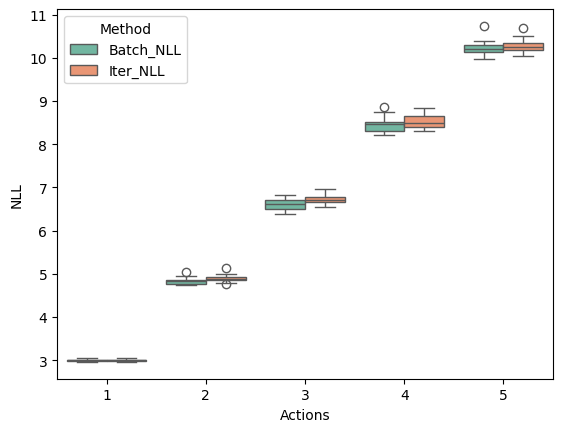

In [210]:
import pandas as pd
import seaborn as sns
testing_df = pd.DataFrame({'Actions': t_values, 
                           'Batch_NLL': batch_NLLs,
                           'Iter_NLL': iter_NLLs})
testing_df = testing_df.melt(id_vars = ['Actions'], var_name = "Method", value_name = "NLL")
sns.boxplot(testing_df, x = 'Actions', y = 'NLL', hue = 'Method', palette = 'Set2')

In [206]:
testing_df

,Actions,Method,NLL
0,1,Batch_NLL,2.994744
1,1,Batch_NLL,3.060846
2,1,Batch_NLL,2.968755
3,1,Batch_NLL,2.995443
4,1,Batch_NLL,2.970617
...,...,...,...
245,5,Iter_NLL,10.338845
246,5,Iter_NLL,10.240255
247,5,Iter_NLL,10.335197
248,5,Iter_NLL,10.104536
